In [2]:
# import libraries
%matplotlib inline
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import glob
import ulmo
import os

In [4]:
ghcn = pd.read_fwf('data/ghcnd-stations.txt', colspecs = [(0,10), (12,19), (21,29), (31,36),(38,39), (41,70), (72,74),(76,78),(80,84)], header = None) 
colnames = ['GHCN ID', 'lat', 'lon', 'elevation', 'state', 'name', 'gsn flag', 'HCN/CRN FLAG', 'WMO ID']
ghcn.columns = colnames

# from http://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt
# FORMAT OF "ghcnd-stations.txt"
#
# ------------------------------
# Variable   Columns   Type
# ------------------------------
# ID            1-11   Character
# LATITUDE     13-20   Real
# LONGITUDE    22-30   Real
# ELEVATION    32-37   Real
# STATE        39-40   Character
# NAME         42-71   Character
# GSN FLAG     73-75   Character
# HCN/CRN FLAG 77-79   Character
# WMO ID       81-85   Character
# ------------------------------

# These variables have the following definitions:

# ID         is the station identification code.  Note that the first two
#            characters denote the FIPS  country code, the third character 
#            is a network code that identifies the station numbering system 
#            used, and the remaining eight characters contain the actual 
#            station ID. 

#            See "ghcnd-countries.txt" for a complete list of country codes.
# 	   See "ghcnd-states.txt" for a list of state/province/territory codes.

#            The network code  has the following five values:

#            0 = unspecified (station identified by up to eight 
# 	       alphanumeric characters)
# 	   1 = Community Collaborative Rain, Hail,and Snow (CoCoRaHS)
# 	       based identification number.  To ensure consistency with
# 	       with GHCN Daily, all numbers in the original CoCoRaHS IDs
# 	       have been left-filled to make them all four digits long. 
# 	       In addition, the characters "-" and "_" have been removed 
# 	       to ensure that the IDs do not exceed 11 characters when 
# 	       preceded by "US1". For example, the CoCoRaHS ID 
# 	       "AZ-MR-156" becomes "US1AZMR0156" in GHCN-Daily
#            C = U.S. Cooperative Network identification number (last six 
#                characters of the GHCN-Daily ID)
# 	   E = Identification number used in the ECA&D non-blended
# 	       dataset
# 	   M = World Meteorological Organization ID (last five
# 	       characters of the GHCN-Daily ID)
# 	   N = Identification number used in data supplied by a 
# 	       National Meteorological or Hydrological Center
# 	   R = U.S. Interagency Remote Automatic Weather Station (RAWS)
# 	       identifier
# 	   S = U.S. Natural Resources Conservation Service SNOwpack
# 	       TELemtry (SNOTEL) station identifier
#            W = WBAN identification number (last five characters of the 
#                GHCN-Daily ID)

# LATITUDE   is latitude of the station (in decimal degrees).

# LONGITUDE  is the longitude of the station (in decimal degrees).

# ELEVATION  is the elevation of the station (in meters, missing = -999.9).


# STATE      is the U.S. postal code for the state (for U.S. stations only).

# NAME       is the name of the station.

# GSN FLAG   is a flag that indicates whether the station is part of the GCOS
#            Surface Network (GSN). The flag is assigned by cross-referencing 
#            the number in the WMOID field with the official list of GSN 
#            stations. There are two possible values:

#            Blank = non-GSN station or WMO Station number not available
#            GSN   = GSN station 

# HCN/      is a flag that indicates whether the station is part of the U.S.
# CRN FLAG  Historical Climatology Network (HCN).  There are three possible 
#           values:

#            Blank = Not a member of the U.S. Historical Climatology 
# 	           or U.S. Climate Reference Networks
#            HCN   = U.S. Historical Climatology Network station
# 	   CRN   = U.S. Climate Reference Network or U.S. Regional Climate 
# 	           Network Station

# WMO ID     is the World Meteorological Organization (WMO) number for the
#            station.  If the station has no WMO number (or one has not yet 
# 	   been matched to this station), then the field is blank.

# --------------------------------------------------------------------------------
# --------------------------------------------------------------------------------

giss = pd.read_fwf('data/v3.temperature.inv.txt',skiprows = 39, header = None,
                  colspecs=[(0,3),(3,8),(8,12), (12,44),(44,49), (52,58), (58,63), (63,67), (67,68), (69,73), (73,75), (75, 77), (78,79), (79,81), (81,82),(82,84), (84,100), (100,102), (103,106)])
colnames = ['icc country code', 'WMO ID', '3 digit modifier', 'name','lat', 'lon', 'elevation', 'TELe', 'P', 'Pop', 'Tp', 'V', 'Lo', 'Co', 'Airport', 'ds', 'Vege', 'bi', 'BI']
giss.columns = colnames

# LEGEND  
# ======
# icc  =3 digit country code; the first digit represents WMO region/continent
# WMO_#=5 digit WMO station number
# ...  =3 digit modifier; 000 means the station is probably the WMO
#       station; 001, etc. mean the station is near that WMO station
# Name =30 character station name
# Lat  =latitude in degrees, negative = South of Equator
# Lon  =longitude in degrees, negative = West of Greenwich (England)
# Elev =station elevation in meters, missing is -999
# TEle =station elevation interpolated from TerrainBase gridded data set
# P    =R if rural (not associated with a town of >10,000 population)
#       S if associated with a small town (10,000-50,000 population)
#       U if associated with an urban area (>50,000 population)
# Pop  =population of the small town or urban area in 1000s
#       If rural, no analysis:  -9.
# Tp   =general topography around the station:  FL flat; HI hilly,
#       MT mountain top; MV mountainous valley or at least not on the top
#       of a mountain.
# V    =general vegetation near the station based on Operational
#       Navigation Charts;  MA marsh; FO forested; IC ice; DE desert;
#       CL clear or open;  xx information not provided
# Lo   =CO if station is within 30 km from the coast
#       LA if station is next to a large (> 25 km**2) lake
#       no if neither of the above
#       Note: Stations which are both CO and LA will be marked CO
# Co   =distance in km to the coast if Lo=CO, else -9
# A    =A if the station is at an airport; else x
# ds   =distance in km from the airport to its associated
#       small town or urban center (not relevant for rural airports
#       or non airport stations in which case ds=-9)
# Vege =gridded vegetation for the 0.5x0.5 degree grid point closest
#       to the station from a gridded vegetation data base. 16 characters.
# bi   =brightness index    A=dark B=dim C=bright   (comment added by R.Ruedy)
# BI   =brightness index    0=dark -> 256 =bright   (based on satellite night light data)

In [18]:
giss[(giss.name.str.contains(city) )& (giss['3 digit modifier']==0)]

,icc country code,WMO ID,3 digit modifier,name,lat,lon,elevation,TELe,P,Pop,Tp,V,Lo,Co,Airport,ds,Vege,bi,BI
513,141,68858,0,EAST LONDON -,33.03,27.83,125,93,U,127,HI,xx,O,5,A,5,COASTAL EDGES,C,15
7219,651,3776,0,LONDON/GATWIC,51.15,-0.18,62,73,U,2332,HI,xx,o,-9,A,15,WARM CROPS,C,29


In [16]:
# given city, look up point
city = 'LONDON'
stationID = giss[(giss.name.str.contains(city) )& (giss['3 digit modifier']==0)]['WMO ID'].values[1]

In [20]:
from shapely.geometry import Point
station1 = Point(giss[giss['WMO ID']== stationID]['lon'], giss[giss['WMO ID']== stationID]['lat'] )

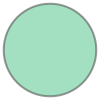

In [22]:
station1.buffer(2)